In [43]:
#https://medium.com/nerd-for-tech/building-an-object-detector-in-tensorflow-using-bounding-box-regression-2bc13992973f

import json
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

In [11]:
categories = ['with_mask', 'without_mask']

f = open ('annotations.json', "r")

data = json.loads(f.read())

images  = []   # Les images d'origine
targets = []   # Les coordonnées des boxes 
labels  = []   # Les catégories des boxes  


width = 180
height = 180
num_classes = len(categories)

In [103]:
# Récupérer les données depuis le json (ie les informations sur les boxes)
def load_data():
    for i in data['data']:
        path = i['image']['path']
        img = image.load_img(path,target_size=(height,width)) #L'image d'origine
        img_arr = image.img_to_array(img)
        #img_arr = tf.expand_dims(img_arr, 0)

        for j in i['image']['boxes']:  # On regarde les boxes correspondantes à l'image d'origine
            if(len(j)!=1):
                w = j['width']
                h = j['height']
                category = j['category']
                xmin = min(j['point top left'][0],j['point bottom right'][0])
                ymin = min(j['point top left'][1],j['point bottom right'][1])
                xmax = max(j['point top left'][0],j['point bottom right'][0])
                ymax = max(j['point top left'][1],j['point bottom right'][1])
                images.append(img_arr)
                targets.append((xmin,ymin,xmax,ymax))
                labels.append(categories.index(category))



load_data()
#print(images)
#print(targets)
#print(labels)

In [104]:
# Si on veut transformer en np array : 
train_images =  np.array(images[0:7])
train_targets = np.array(targets[0:7])
train_labels =  np.array(labels[0:7])

validation_images =  np.array(images[8:14])
validation_targets = np.array(targets[8:14])
validation_labels =  np.array(labels[8:14])

input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers

base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)


classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)  

locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])


losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tf.keras.losses.MSE}
    
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 bl_1 (Rescaling)               (None, 180, 180, 3)  0           ['input_7[0][0]']                
                                                                                                  
 bl_2 (Conv2D)                  (None, 180, 180, 16  448         ['bl_1[0][0]']                   
                                )                                                                 
                                                                                            

[ 4.0202694 -9.275706 ]
[50.693405 48.087704 52.220726 51.022625]


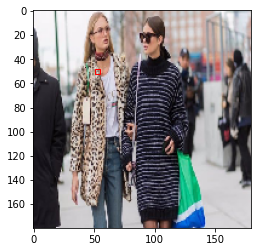

In [108]:
predictions = model.predict(validation_images)
#print(predictions)
#print(len(predictions[0])+len(predictions[1]))
box0 = predictions[0][4] * 100
box1 = predictions[1][4] * 100

xmin = min(box1[0],box1[2])
ymin = min(box1[1], box1[3])

print(box0)
print(box1)

fig, ax = plt.subplots()

ax.imshow((validation_images[4] * 1).astype(np.uint8))
#add rectangle to plot
ax.add_patch(Rectangle((xmin, ymin), box0[0], box0[0],linewidth=1,edgecolor='r',facecolor='none'))

plt.show()